# Estimated beta vs MAF analysis

The goal of this analysis is to see the correlation between MAF and rescaled marginal effect size.

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import random
from matplotlib.axes import Axes


In [2]:
random.seed(42)
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.0)
sns.set_palette(sns.color_palette("rocket"))


In [3]:
dataset = pl.read_parquet("../../data/rescaled-betas.parquet")
known_cs = pl.read_parquet("../../data/known_studyLocusIds/*.parquet")


In [4]:
def format_int_with_commas(x):
    """Format an integer with commas as thousand separators."""
    return f"{x:,}"


def classify_study_locus(all: pl.DataFrame, known: pl.DataFrame) -> pl.DataFrame:
    """Classify study locus ids based on known or novel."""
    assert "studyLocusId" in all.columns and "studyLocusId" in known.columns
    known = known.with_columns(pl.lit("known").alias("studyLocusClass"))
    classified = all.join(known, on="studyLocusId", how="left")
    return classified.with_columns(
        pl.when(pl.col("studyLocusClass") == "known")
        .then(pl.lit("known"))
        .otherwise(pl.lit("novel"))
        .alias("studyLocusClass")
    )


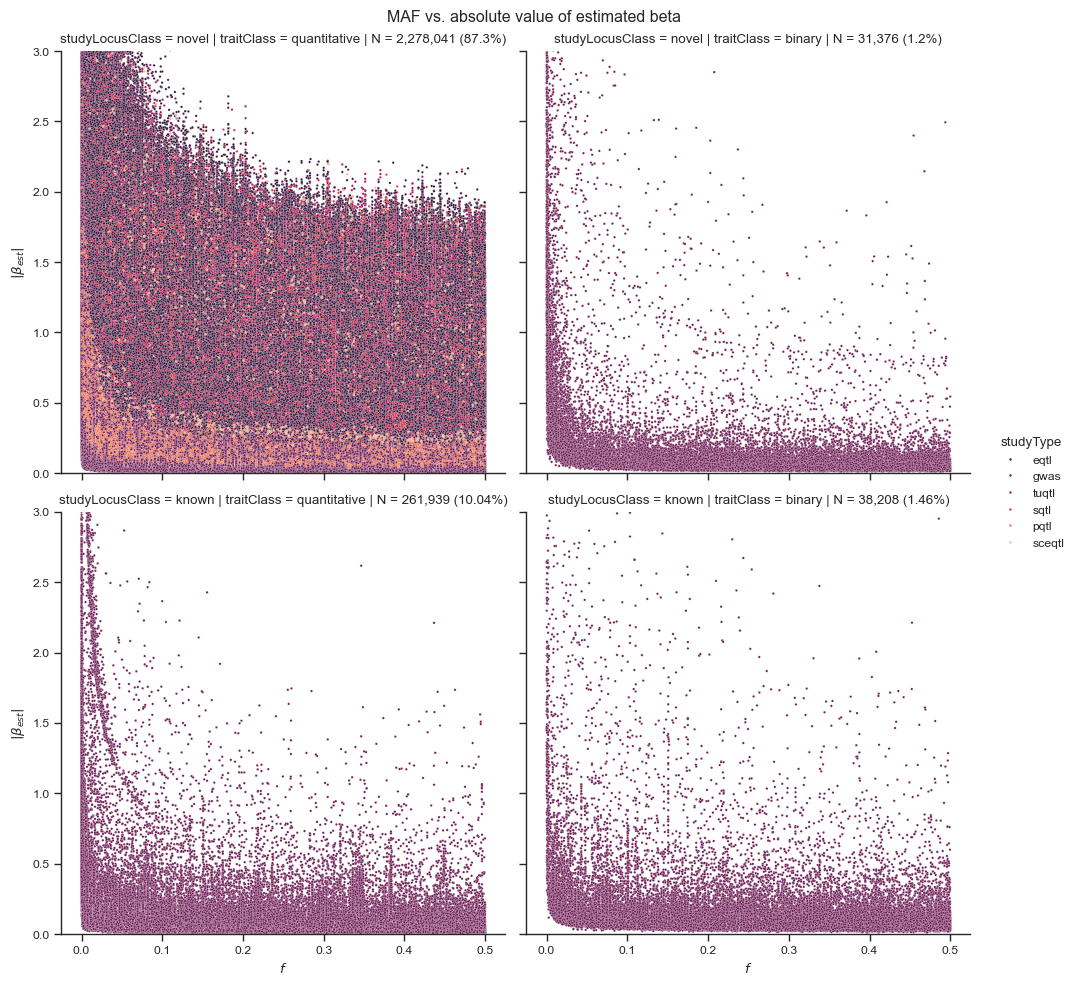

In [7]:
# plot est beta vs maf

data = dataset.select(
    pl.col("majorPopulationMAF"),
    pl.col("rescaledStatistics").struct.field("estimatedBeta").abs().alias("absEstimatedBeta"),
    pl.col("studyType"),
    pl.col("rescaledStatistics").struct.field("traitClass"),
    pl.col("studyLocusId"),
).filter(pl.col("majorPopulationMAF").is_not_null() & pl.col("absEstimatedBeta").is_finite())
data = classify_study_locus(data, known_cs)

g = sns.relplot(
    data=data,
    x="majorPopulationMAF",
    y="absEstimatedBeta",
    col="traitClass",
    row="studyLocusClass",
    hue="studyType",
    s=3,
)

g.figure.suptitle("MAF vs. absolute value of estimated beta")
for ax in g.axes.flatten():
    if isinstance(ax, Axes):
        ax.set_xlabel("$f$")
        ax.set_ylabel(r"$\vert\beta_{est}\vert$")
        ax.set_ylim(0, 3)
        title = ax.get_title()
        trait_class = title.split(" | ")[1].split(" = ")[-1]
        cs_class = title.split(" | ")[0].split(" = ")[-1]
        n_total = data.shape[0]
        n = data.filter(pl.col("traitClass") == trait_class).filter(pl.col("studyLocusClass") == cs_class).shape[0]
        ax.set_title(f"{title} | N = {format_int_with_commas(n)} ({round(n / n_total * 100, 2)}%)")
g.tight_layout()
plt.show()


Plot the same plots for MAF vs abs(beta) for binary and quantitative traits 

In [11]:
data = dataset.select(
    pl.col("majorPopulationMAF"),
    pl.col("rescaledStatistics").struct.field("estimatedBeta").abs().alias("absEstimatedBeta"),
    pl.col("studyType"),
    pl.col("rescaledStatistics").struct.field("traitClass"),
    pl.col("studyLocusId"),
).filter(pl.col("majorPopulationMAF").is_not_null() & pl.col("absEstimatedBeta").is_finite())
data = classify_study_locus(data, known_cs)
data.group_by("traitClass", "studyLocusClass").agg(pl.len()).select(
    pl.col("traitClass"),
    pl.col("studyLocusClass"),
    pl.col("len").alias("count"),
    (pl.col("len") / pl.sum("len") * 100).round(2).alias("%"),
).sort("%")


traitClass,studyLocusClass,count,%
str,str,u32,f64
"""binary""","""novel""",31376,1.2
"""binary""","""known""",38208,1.46
"""quantitative""","""known""",261939,10.04
"""quantitative""","""novel""",2278041,87.3
